In [1]:
from typing import Union, Type

import numpy as np
import pandas as pd
import seaborn as sns
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import ADAM, COBYLA
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
from qiskit.primitives import Estimator
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

sns.set(style='whitegrid')
from qiskit.algorithms.optimizers import L_BFGS_B
from qiskit_machine_learning.algorithms import VQR, NeuralNetworkRegressor
import warnings

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

n_of_samples = 70

random_state = 80

# Data Preparing

In [2]:
diamond_data = pd.read_csv('../datasets/diamonds.csv')

In [3]:
diamond_data = diamond_data.sample(n=1000, random_state=random_state)

In [4]:
diamond_data = diamond_data.drop(["Unnamed: 0"], axis=1)

In [5]:
diamond_data[['x', 'y', 'z']] = diamond_data[['x', 'y', 'z']].replace(0, np.NaN)
diamond_data.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [6]:
diamond_data.dropna(inplace=True)
diamond_data.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [7]:
diamond_data['volume'] = diamond_data['x'] * diamond_data['y'] * diamond_data['z']
diamond_data.drop(['x', 'y', 'z'], axis=1, inplace=True)
diamond_data.head()

,carat,cut,color,clarity,depth,table,price,volume
21394,1.51,Very Good,I,VS1,63.1,53.0,9513,244.789000
45561,0.52,Ideal,E,VS2,62.6,57.0,1689,84.472113
46725,0.47,Very Good,D,VS1,60.0,59.0,1795,78.967278
33918,0.30,Premium,E,VS2,62.9,58.0,844,48.111798
40863,0.56,Very Good,I,SI1,61.8,56.0,1175,89.914500


In [8]:
def outliers(var):
    a = []
    q1 = diamond_data[var].quantile(.25)
    q3 = diamond_data[var].quantile(.75)
    iqr = q3 - q1
    ulim = float(q3 + (1.5 * iqr))
    llim = float(q1 - (1.5 * iqr))

    for iterator in diamond_data[var]:
        if iterator > ulim:
            iterator = np.NaN
        elif iterator < llim:
            iterator = np.NaN
        else:
            iterator = iterator
        a.append(iterator)
    return a


for col in diamond_data.select_dtypes(exclude='object').columns:
    diamond_data[col] = outliers(col)

In [9]:
for i in diamond_data.select_dtypes(exclude='object').columns:
    diamond_data[i] = diamond_data[i].fillna(diamond_data[i].mean())

In [10]:
numerical_cols = diamond_data.select_dtypes(include=np.number).columns.to_list()
categorical_cols = diamond_data.select_dtypes(exclude=np.number).columns.to_list()

In [11]:
label_encoder = preprocessing.LabelEncoder()

diamond_data['cut'] = label_encoder.fit_transform(diamond_data['cut'])
diamond_data['color'] = label_encoder.fit_transform(diamond_data['color'])
diamond_data['clarity'] = label_encoder.fit_transform(diamond_data['clarity'])
diamond_data.head()

,carat,cut,color,clarity,depth,table,price,volume
21394,1.51,4,5,4,63.1,53.0,9513.0,244.789000
45561,0.52,2,1,5,62.6,57.0,1689.0,84.472113
46725,0.47,4,0,4,60.0,59.0,1795.0,78.967278
33918,0.30,3,1,5,62.9,58.0,844.0,48.111798
40863,0.56,4,5,2,61.8,56.0,1175.0,89.914500


# Scaling

In [12]:
X = diamond_data.drop(columns=['price'])
y = diamond_data['price']

y = StandardScaler().fit_transform(y.to_numpy().reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=345356)

# Classical approach

In [13]:
regr = LinearRegression()
model = regr.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("R2  : {}".format(np.sqrt(r2_score(y_test, y_pred))))

RMSE: 0.5656605913278987
R2  : 0.8365463296188355


# Reduction number of features

In [14]:
fs = SelectKBest(score_func=f_regression, k='all')

fs.fit(X_train, y_train)

best_features = pd.DataFrame([fs.scores_, X_train.columns]).T.sort_values(0, ascending=False)

### We take two first best features to not kill our quantum algorithm simulator

In [15]:
n_of_best_features = 2
X_train_features_reduced, X_test_features_reduced = \
    X_train.loc[:, best_features.iloc[:n_of_best_features].loc[:, 1].values], \
        X_test.loc[:, best_features.iloc[:n_of_best_features].loc[:, 1].values]

# Score is not so much smaller than the one with all features ^^^^

In [16]:
regr = LinearRegression()
model = regr.fit(X_train_features_reduced, y_train)
y_pred = model.predict(X_test_features_reduced)

print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("R2  : {}".format(np.sqrt(r2_score(y_test, y_pred))))

RMSE: 0.5790897222639099
R2  : 0.827881130908127


# Quantum approach

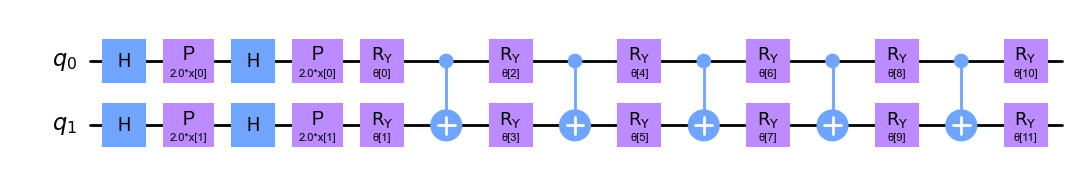

In [17]:
n_features = X_train_features_reduced.shape[1]

feature_map = ZFeatureMap(n_features)
ansatz = RealAmplitudes(n_features, reps=5)

initial_point = algorithm_globals.random.random(ansatz.num_parameters)

circuit = QuantumCircuit(n_features)
circuit.compose(feature_map, inplace=True)
circuit.compose(ansatz, inplace=True)

estimator_qnn = EstimatorQNN(
    circuit=circuit,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=Estimator()
)
circuit.decompose().draw(output="mpl")

# NeuralNetworkRegressor

In [18]:
def get_neural_network_regressor(optimizer: Union[Type[ADAM], Type[L_BFGS_B], Type[COBYLA]]):
    in_regressor = NeuralNetworkRegressor(
        neural_network=estimator_qnn,
        optimizer=optimizer(maxiter=1000),
        initial_point=initial_point,
    )
    # L_BFGS_B NeuralNetworkRegressor

    return in_regressor


In [19]:
regressor = get_neural_network_regressor(ADAM)
regressor.fit(X_train_features_reduced.to_numpy(), y_train)

y_pred = regressor.predict(X_test_features_reduced)

print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("R2  : {}".format(np.sqrt(r2_score(y_test, y_pred))))

RMSE: 0.6150024245446807
R2  : 0.8032155733811304


In [20]:
regressor = get_neural_network_regressor(L_BFGS_B)
regressor.fit(X_train_features_reduced.to_numpy(), y_train)

y_pred = regressor.predict(X_test_features_reduced)

print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("R2  : {}".format(np.sqrt(r2_score(y_test, y_pred))))

RMSE: 0.6071645006567055
R2  : 0.8087906337944423


In [21]:
regressor = get_neural_network_regressor(COBYLA)
regressor.fit(X_train_features_reduced.to_numpy(), y_train)

y_pred = regressor.predict(X_test_features_reduced)

print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("R2  : {}".format(np.sqrt(r2_score(y_test, y_pred))))

RMSE: 0.6071640788784658
R2  : 0.8087909308508446


# VQR with L_BFGS_B

In [22]:
def get_vqr(optimizer: Union[Type[ADAM], Type[L_BFGS_B], Type[COBYLA]]):
    int_regressor = VQR(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer(maxiter=1000),
        initial_point=initial_point
    )
    return int_regressor

In [23]:
regressor = get_vqr(ADAM)

regressor.fit(X_train_features_reduced.to_numpy(), y_train)

y_pred = regressor.predict(X_test_features_reduced)

print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("R2  : {}".format(np.sqrt(r2_score(y_test, y_pred))))

RMSE: 0.6150024245446807
R2  : 0.8032155733811304


In [24]:
regressor = get_vqr(L_BFGS_B)

regressor.fit(X_train_features_reduced.to_numpy(), y_train)

y_pred = regressor.predict(X_test_features_reduced)

print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("R2  : {}".format(np.sqrt(r2_score(y_test, y_pred))))

RMSE: 0.6071645006567055
R2  : 0.8087906337944423


In [25]:
regressor = get_vqr(COBYLA)

regressor.fit(X_train_features_reduced.to_numpy(), y_train)

y_pred = regressor.predict(X_test_features_reduced)

print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("R2  : {}".format(np.sqrt(r2_score(y_test, y_pred))))

RMSE: 0.6071640788784658
R2  : 0.8087909308508446


## Scores are comparable